<a href="https://colab.research.google.com/github/tx871217/IndependentStudy_Mango_1/blob/master/Mango_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Input & Processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Attempt To Show Raw Image

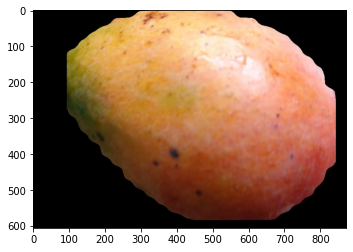

In [ ]:
import cv2
from matplotlib import pyplot as plt

# img_dir="/content/drive/My Drive/img/Train/A/00005.jpg"
# img_dir="/content/drive/My Drive/img/Train/C/00002.jpg"
img_dir="/content/drive/My Drive/img/Train/C/03624.jpg"
# img_dir="/content/drive/My Drive/org_noback_nobackCyGan/Train/A/00005 (2).jpg"
# img_dir="/content/drive/My Drive/org_noback_nobackCyGan/Train/B/00009 (2).jpg"
# img_dir="/content/drive/My Drive/org_noback_nobackCyGan/Train/C/00002 (2).jpg"

org_image = cv2.imread(img_dir)
show_img = cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB)
plt.imshow(show_img)
plt.show()

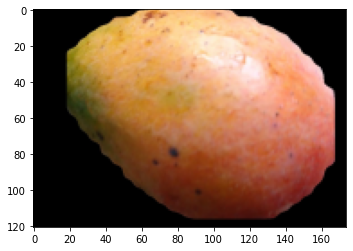

In [ ]:
resized = cv2.resize(org_image, (org_image.shape[1]//5, org_image.shape[0]//5), interpolation = cv2.INTER_AREA)
show_img = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
plt.imshow(show_img)
plt.show()

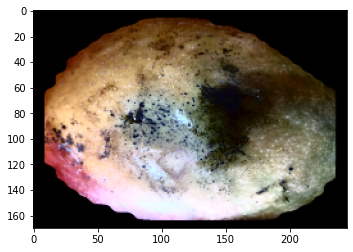

In [ ]:
def hisEqulColor(img):
    ycrcb=cv2.cvtColor(img,cv2.COLOR_BGR2YCR_CB)
    channels=cv2.split(ycrcb)
    cv2.equalizeHist(channels[0],channels[0])
    cv2.merge(channels,ycrcb)
    cv2.cvtColor(ycrcb,cv2.COLOR_YCR_CB2BGR,img)
    return img
equ=hisEqulColor(resized)
show_img = cv2.cvtColor(equ, cv2.COLOR_BGR2RGB)
plt.imshow(show_img)
plt.show()

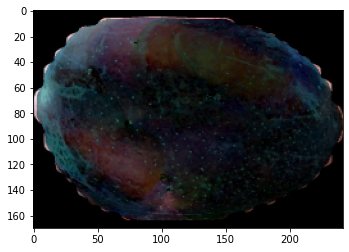

In [ ]:
corrected=cv2.morphologyEx(resized, cv2.MORPH_TOPHAT,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(50,50)))
show_img = cv2.cvtColor(corrected, cv2.COLOR_BGR2RGB)
plt.imshow(show_img)
plt.show()

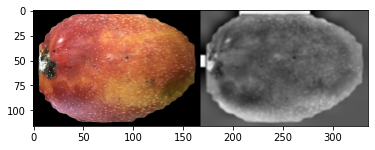

In [ ]:
import cv2
import numpy as np

def unevenLightCompensate(img, blockSize):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    average = np.mean(gray)

    rows_new = int(np.ceil(gray.shape[0] / blockSize))
    cols_new = int(np.ceil(gray.shape[1] / blockSize))

    blockImage = np.zeros((rows_new, cols_new), dtype=np.float32)
    for r in range(rows_new):
        for c in range(cols_new):
            rowmin = r * blockSize
            rowmax = (r + 1) * blockSize
            if (rowmax > gray.shape[0]):
                rowmax = gray.shape[0]
            colmin = c * blockSize
            colmax = (c + 1) * blockSize
            if (colmax > gray.shape[1]):
                colmax = gray.shape[1]

            imageROI = gray[rowmin:rowmax, colmin:colmax]
            temaver = np.mean(imageROI)
            blockImage[r, c] = temaver

    blockImage = blockImage - average
    blockImage2 = cv2.resize(blockImage, (gray.shape[1], gray.shape[0]), interpolation=cv2.INTER_CUBIC)
    gray2 = gray.astype(np.float32)
    dst = gray2 - blockImage2
    dst = dst.astype(np.uint8)
    dst = cv2.GaussianBlur(dst, (3, 3), 0)
    dst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)

    return dst

blockSize = 16
# img = cv2.imread(file)
dst = unevenLightCompensate(resized, blockSize)

result = np.concatenate([resized, dst], axis=1)


show_img = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.imshow(show_img)
plt.show()

# Run all Defs

In [ ]:
import numpy as np
import cv2

def object_area(org_image):
  obj_area=0
  kernel = np.ones((5,5),np.uint8)
  gray = cv2.cvtColor(org_image, cv2.COLOR_BGR2GRAY)
  thresh = cv2.threshold(gray, 0 ,255, cv2.THRESH_OTSU)[1]
  thresh = cv2.erode(thresh,kernel,iterations=5)
  thresh = cv2.dilate(thresh,kernel,iterations=5)
  for i in range(thresh.shape[0]):
    for j in range(thresh.shape[1]):
      if gray[i][j]!=0:
        obj_area+=1#counting the whole object area

  return obj_area

def ostu_cc(org_image):
  #get gray
  gray = cv2.cvtColor(org_image, cv2.COLOR_BGR2GRAY)
  #get ostu
  kernel = np.ones((5,5),np.uint8)
  thresh = cv2.threshold(gray, 0 ,255, cv2.THRESH_OTSU)[1]
  thresh = cv2.erode(thresh,kernel,iterations=5)
  thresh = cv2.dilate(thresh,kernel,iterations=5)
  #get background
  bg = cv2.threshold(gray, 0 ,255, cv2.THRESH_BINARY)[1]
  kernel = np.ones((5,5),np.uint8)
  bg=cv2.erode(bg,kernel,iterations=7)#iterations need to change with image size
  #take off background
  obj_area=0
  defects_area=0
  new=[]
  for i in range(thresh.shape[0]):
    ar=[]
    for j in range(thresh.shape[1]):
      if bg[i][j]==0:# if this pixel is black
        ar.append(255)# make the same position in new image is white
      else:
        ar.append(thresh[i][j])# or append the original pixel
      if ar[j]==0:
        defects_area+=1#counting the black pixels
      if gray[i][j]!=0:
        obj_area+=1#counting the whole object area
    new.append(ar)
  new=np.array(new,dtype=np.uint8) # the numpy default dtype is int64, it can't be used in cvtColor
  #reverse b/w
  new_convert=[]
  for i in range(new.shape[0]):
    array=[]
    for j in range(new.shape[1]):
      if new[i][j] == 255:
        array.append(0)
      else:
        array.append(255)
    new_convert.append(array)
  new_convert=np.array(new_convert,dtype=np.uint8)
  #convert defects with colors
  num,labels=cv2.connectedComponents(new_convert)
  label_hue = np.uint8(179*labels/np.max(labels))
  blank_ch = 255*np.ones_like(label_hue)
  labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
  labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
  labeled_img[label_hue==0] = 0 
  #detect different colors area
  defects_gray=cv2.cvtColor(labeled_img,cv2.COLOR_BGR2GRAY)
  counts=[]
  for i in range(0,255):
    counts.append(0)
  for i in defects_gray:
    for j in i:
      if j!=0:
        counts[int(j)]+=1
  for i in range(len(counts)):
    counts[i]=counts[i]/obj_area
  rates=sorted(counts,reverse=True)
  lst=[]
  for i in range(100):
    lst.append(0)
  rates=rates[:num-1]
  for i in rates:
    if i<8.52e-07:
      lst[99]+=1
    elif i>=0.86:
      lst[0]+=1
    else:
      lst[int(-math.log(i)/math.log(1.15))]+=1

  return lst

from skimage.feature import hog
def hog_rates(hog_image,obj_size):
  counts=[]
  for i in range(100):
    counts.append(0)
  for i in hog_image:
    for j in i:
      if j!=0:
        counts[int(j*100/255)]+=1
  for i in range(len(counts)):
    counts[i]=counts[i]/obj_size
  return counts

def RGB_rates(RGB):
  cnts=[]
  for i in range(37):
    cnts.append(0)
  for i in RGB:
    for j in i:
      cnts[int(j/7)]+=1
  cnts[0]-=org_image.shape[0]*org_image.shape[1]-obj_size
  for i in range(len(cnts)):
    cnts[i]=cnts[i]/obj_size
  return cnts

def list_features():
  features=[]
  features.append("id,")
  for i in range(100):
    features.append("df-"+str(i)+",")
  for i in range(100):
    features.append("hog-"+str(i)+",")
  for i in range(37):
    features.append("R-"+str(i)+",")
  for i in range(37):
    features.append("G-"+str(i)+",")
  for i in range(37):
    features.append("B-"+str(i)+",")
  features.append("target")
  return features

# Run all

In [ ]:
import os
from tqdm import tqdm
progress = tqdm(total=6400)

folders=[]
folder_path = '/content/drive/My Drive/img/'
folders.append(folder_path+"Train/A")
folders.append(folder_path+"Train/B")
folders.append(folder_path+"Train/C")
folders.append(folder_path+"Dev/A")
folders.append(folder_path+"Dev/B")
folders.append(folder_path+"Dev/C")

folder_content = os.listdir(folder_path)
LF=list_features()
csv_file = open("/content/drive/My Drive/data/mango1.csv","w")

# write features(first row)
for i in LF:
  csv_file.write(i)
csv_file.write("\n")
# wirte contents
for c in folders:
  folder_content = os.listdir(c)
  for item in folder_content:
    progress.update(1)
    f = c +"/"+ item
    org_image = cv2.imread(f)
    resized = cv2.resize(org_image, (org_image.shape[1]//5, org_image.shape[0]//5), interpolation = cv2.INTER_AREA)
    csv_file.write(item+",")
    obj_size=object_area(resized)
    for i in ostu_cc(resized):
      csv_file.write(str(i)+",")
    fd, hog_image = hog(resized, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(1, 1), visualize=True, multichannel=True)
    for i in hog_rates(hog_image,obj_size):
      csv_file.write(str(i)+",")
    b, g, r = cv2.split(resized)
    for i in RGB_rates(r):
      csv_file.write(str(i)+",")
    for i in RGB_rates(g):
      csv_file.write(str(i)+",")
    for i in RGB_rates(b):
      csv_file.write(str(i)+",")
    csv_file.write(c[-1])
    csv_file.write("\n")
csv_file.close()

Streaming output truncated to the last 5000 lines.

 61%|██████    | 3901/6400 [1:19:05<41:34,  1.00it/s]

 61%|██████    | 3902/6400 [1:19:06<40:26,  1.03it/s]

 61%|██████    | 3903/6400 [1:19:07<36:46,  1.13it/s]

 61%|██████    | 3904/6400 [1:19:08<44:57,  1.08s/it]

 61%|██████    | 3905/6400 [1:19:10<50:03,  1.20s/it]

 61%|██████    | 3906/6400 [1:19:12<58:35,  1.41s/it]

 61%|██████    | 3907/6400 [1:19:13<56:17,  1.35s/it]

 61%|██████    | 3908/6400 [1:19:14<56:12,  1.35s/it]

 61%|██████    | 3909/6400 [1:19:15<48:55,  1.18s/it]

 61%|██████    | 3910/6400 [1:19:16<45:49,  1.10s/it]

 61%|██████    | 3911/6400 [1:19:17<40:32,  1.02it/s]

 61%|██████    | 3912/6400 [1:19:18<46:38,  1.12s/it]

 61%|██████    | 3913/6400 [1:19:19<44:11,  1.07s/it]

 61%|██████    | 3914/6400 [1:19:20<45:24,  1.10s/it]

 61%|██████    | 3915/6400 [1:19:21<43:07,  1.04s/it]

 61%|██████    | 3916/6400 [1:19:22<41:55,  1.01s/it]

 61%|██████    | 3917/6400 [1:19:23<37:49,  1.09it/s]

 61%|██████  

# OSTU+ConnectedComponents

get defects in mango and mask

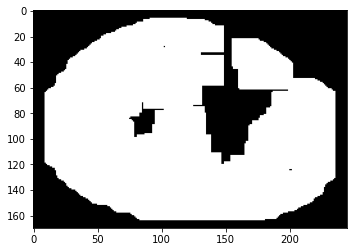

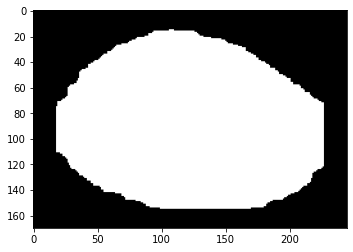

In [ ]:
import numpy as np

image = cv2.imread(img_dir)
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

kernel = np.ones((5,5),np.uint8)

thresh = cv2.threshold(gray, 0 ,255, cv2.THRESH_OTSU)[1]
# th_kernal=np.ones(())
thresh = cv2.erode(thresh,kernel,iterations=5)
thresh = cv2.dilate(thresh,kernel,iterations=5)

bg = cv2.threshold(gray, 0 ,255, cv2.THRESH_BINARY)[1]
kernel = np.ones((5,5),np.uint8)
bg=cv2.erode(bg,kernel,iterations=5)
# https://stackoom.com/question/3ysdi/%E5%A6%82%E4%BD%95%E5%9C%A8OpenCV%E4%B8%AD%E4%BB%8E%E5%9B%BE%E5%83%8F%E4%B8%AD%E6%8F%90%E5%8F%96%E6%9D%A1%E7%BA%B9%E5%8C%BA%E5%9F%9F

show_img = cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB)
plt.imshow(show_img)
plt.show()
show_img = cv2.cvtColor(bg, cv2.COLOR_BGR2RGB)
plt.imshow(show_img)
plt.show()

take off mango

defects' area 2742
mango's area 30243
area's rate 0.09066560857057832


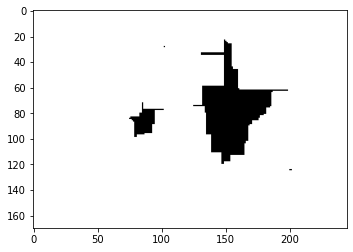

In [ ]:
import numpy

obj_area=0
defects_area=0
new=[]

for i in range(thresh.shape[0]):
  ar=[]
  for j in range(thresh.shape[1]):
    if bg[i][j]==0:# if this pixel is black
      ar.append(255)# make the same position in new image is white
    else:
      ar.append(thresh[i][j])# or append the original pixel
    if ar[j]==0:
      defects_area+=1#counting the black pixels
    if gray[i][j]!=0:
      obj_area+=1#counting the whole object area
  new.append(ar)

area_rate=defects_area/obj_area #
print("defects' area",defects_area)
print("mango's area",obj_area)
print("area's rate",defects_area/obj_area)

new=numpy.array(new,dtype=numpy.uint8) # the numpy default dtype is int64, it can't be used in cvtColor
# print(thresh.shape)
# print(new.dtype)
show_img = cv2.cvtColor(new, cv2.COLOR_BGR2RGB)
plt.imshow(show_img)
plt.show()

reverse the images

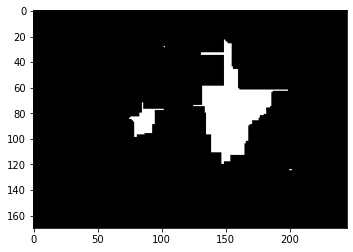

In [ ]:
new_convert=[]
for i in range(new.shape[0]):
  array=[]
  for j in range(new.shape[1]):
    if new[i][j] == 255:
      array.append(0)
    else:
      array.append(255)
  new_convert.append(array)

new_convert=numpy.array(new_convert,dtype=numpy.uint8)

show_img = cv2.cvtColor(new_convert, cv2.COLOR_BGR2RGB)
plt.imshow(show_img)
plt.show()

convert all connected components to different color

4


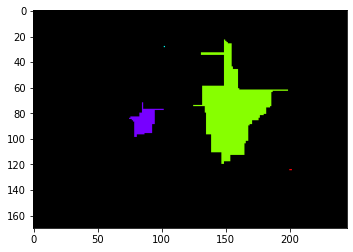

In [ ]:
import numpy as np

num,labels=cv2.connectedComponents(new_convert)

label_hue = np.uint8(179*labels/np.max(labels))
blank_ch = 255*np.ones_like(label_hue)

labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
# cvt to BGR for display
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

labeled_img[label_hue==0] = 0

print(num-1)

show_img = cv2.cvtColor(labeled_img, cv2.COLOR_BGR2RGB)
plt.imshow(show_img)
plt.show()

In [ ]:
defects_gray=cv2.cvtColor(labeled_img,cv2.COLOR_BGR2GRAY)

def defects_rates(defects_gray,obj_size):
  lst=[]
  counts=[]
  for i in range(0,255):
    counts.append(0)

  for i in range(100):
    lst.append(0)

  for i in defects_gray:
    for j in i:
      if j!=0:
        counts[int(j)]+=1

  for i in range(len(counts)):
    counts[i]=counts[i]/obj_size

  rates=sorted(counts,reverse=True)
  rates=rates[:num-1]
  # print(rates)
  for i in rates:
    # y=math.log(i)
    # print(y)
    # print(int(-y/math.log(1.15)))
    if i<8.52e-07:
      lst[99]+=1
    elif i>=0.86:
      lst[0]+=1
    else:
      lst[int(-math.log(i)/math.log(1.15))]+=1

  return lst

print(defects_rates(defects_gray,object_area(resized)))
# print(sum())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


1: 0.8695652173913044
2: 0.7561436672967865
50: 0.0009228008424307284
100: 8.515613947908619e-07


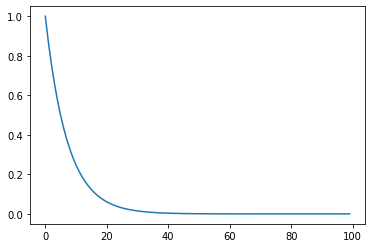

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math

# Create the vectors X and Y
x = np.array(range(100))
# y = 0.0007286485*x*x-0.1507286485*x+1
# y=np.exp(-x)
z=1.15
y=z**(-x)
print("1:",z**(-1))
print("2:",z**(-2))
print("50:",z**(-50))
print("100:",z**(-100))
# print(int(-math.log(0.75)/math.log(1.15)))
# Create the plot
plt.plot(x,y)

# Show the plot
plt.show()

# HOG

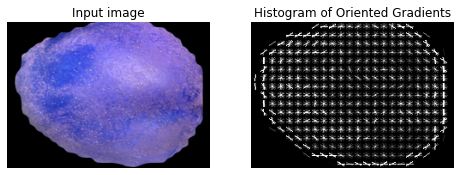

In [ ]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import exposure

fd, hog_image = hog(resized, orientations=9, pixels_per_cell=(10, 10),
                    cells_per_block=(2, 2), visualize=True, multichannel=True)#transform_sqrt = True,


#display
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(resized, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [ ]:
 import cv2
 hog = cv2.HOGDescriptor()
#  im = cv2.imread(resized)
 h = hog.compute(resized)
#  print(h[:10])
 print(sorted(h,reverse=True)[0:12])

[array([0.96308386], dtype=float32), array([0.96308386], dtype=float32), array([0.96308386], dtype=float32), array([0.96308386], dtype=float32), array([0.96308386], dtype=float32), array([0.96308386], dtype=float32), array([0.96308386], dtype=float32), array([0.96308386], dtype=float32), array([0.96308386], dtype=float32), array([0.96308386], dtype=float32), array([0.9368637], dtype=float32), array([0.9368637], dtype=float32)]


In [ ]:
# for i in hog_image:
#   for j in i:
#     if j!=0:
#       print(j)
sum(fd)/object_area(resized)
#a
#0.002095107339510963
#c
#0.0022231470571369874
#0.0022091467088580425
#0.002092069873661447

0.0563243793614578

In [ ]:
from skimage.feature import hog

# hog_features=[]
# for i in range(0,255):
#   hog_features.append("hog_"+str(i))
#   counts.append(0)

def hog_rates(hog_image,obj_size):
  
  counts=[]
  for i in range(0,255):
    counts.append(0)

  for i in hog_image:
    for j in i:
      if j!=0:
        counts[int(j)]+=1

  for i in range(len(counts)):
    counts[i]=counts[i]/obj_size
  
  return counts

In [ ]:
c=hog_rates(hog_image,object_area(org_image))
print(c)

[0.1769647215325053, 0.09653681144980113, 0.05123102321600343, 0.0305297997450771, 0.01944648341543688, 0.012628223303980984, 0.008728856901335298, 0.006292249760844161, 0.004508849428543415, 0.0034276795391248354, 0.0025558538194711275, 0.0020775421404513883, 0.0016694535057198657, 0.0013527873248730022, 0.0010573205536225816, 0.0009208493543454815, 0.0006823559963855006, 0.0005935834687003967, 0.00046373708492218493, 0.00039748892993330136, 0.0003365406273435285, 0.00029679173435019835, 0.0002398183210597585, 0.0002755923247537556, 0.00021464402216398273, 0.00022656869006198178, 0.00018681979706865163, 0.00017092023987131958, 0.00015502068267398753, 0.00017622009227043027, 0.00016827031367176425, 0.00010467208488243603, 0.00012719645757865644, 8.74475645853263e-05, 8.877252768510397e-05, 5.432348709088452e-05, 8.214771218621561e-05, 6.094830258977287e-05, 9.009749078488164e-05, 6.624815498888356e-05, 6.094830258977287e-05, 5.697341329043986e-05, 4.1073856093107806e-05, 5.564845019066

In [ ]:

# lmax=[]
# cnt=0
# for i in hog_image:
#   lmax.append(max(i))
#   for j in i:
#     if j!=0:
#       cnt+=j
# print(max(lmax))
# print(cnt)

87.3598837852478
0.0
166883.22907541692


In [ ]:
import cv2
from matplotlib import pyplot as plt
from skimage.feature import hog
import numpy as np

def object_area(org_image):
  obj_area=0
  kernel = np.ones((5,5),np.uint8)
  gray = cv2.cvtColor(org_image, cv2.COLOR_BGR2GRAY)
  thresh = cv2.threshold(gray, 0 ,255, cv2.THRESH_OTSU)[1]
  thresh = cv2.erode(thresh,kernel,iterations=5)
  thresh = cv2.dilate(thresh,kernel,iterations=5)
  for i in range(thresh.shape[0]):
    for j in range(thresh.shape[1]):
      if gray[i][j]!=0:
        obj_area+=1#counting the whole object area

  return obj_area

A1="/content/drive/My Drive/img/Train/A/00017.jpg"#L
A2="/content/drive/My Drive/img/Train/A/00005.jpg"#M
A3="/content/drive/My Drive/img/Train/A/00007.jpg"#L
A4="/content/drive/My Drive/img/Train/A/00081.jpg"#L
B1="/content/drive/My Drive/img/Train/B/00009.jpg"#H
B2="/content/drive/My Drive/img/Train/B/00038.jpg"#H
B3="/content/drive/My Drive/img/Train/B/00055.jpg"#H
B4="/content/drive/My Drive/img/Train/B/00084.jpg"#H
B5="/content/drive/My Drive/img/Train/B/00091.jpg"#H
C1="/content/drive/My Drive/img/Train/C/00029.jpg"#H
C2="/content/drive/My Drive/img/Train/C/00002.jpg"#H

abc_lst=[A1,A2,A3,A4,B1,B2,B3,B4,B5,C1,C2]
# img_lst=[]
for img_dir in abc_lst:
  # img_lst.append(cv2.imread(img_dir))
  org_image=cv2.imread(img_dir)
  resized = cv2.resize(org_image, (org_image.shape[1]//5, org_image.shape[0]//5), interpolation = cv2.INTER_AREA)
  fd, hog_image = hog(resized, orientations=9, pixels_per_cell=(20, 20),
                    cells_per_block=(2, 2), visualize=True,transform_sqrt = True, multichannel=True)#
  print(img_dir[-11:]+":"+str(sum(fd)/len(fd)))#/object_area(resized)))

A/00017.jpg:0.15002538053438083
A/00005.jpg:0.14233717251980785
A/00007.jpg:0.14958890891649723
A/00081.jpg:0.15304333301022904
B/00009.jpg:0.14005966635039388
B/00038.jpg:0.13222086037775535
B/00055.jpg:0.14585491416862273
B/00084.jpg:0.14701028052777054
B/00091.jpg:0.1481406670670811
C/00029.jpg:0.1516879407720922
C/00002.jpg:0.14209349330060767


# RGB

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# 顯示指定資料夾的內容
folder_path = 'D:/machinelearning/graduate_project_mango/RGB/whiteback_mask/Train/img/C'
folder_content = os.listdir(folder_path)

RGB_lst = []
name_lst = []
for i in ('b','g','r'):
    for j in range(86): #86種bins
        name = '%s%s' % (i, j)
        name_lst.append(name)
RGB_lst.append(name_lst)
for item in folder_content:
    file = folder_path + '/' + item
    img = cv2.imread(file)
    
    # 畫出 RGB 三種顏色的分佈圖
    color = ('b','g','r')
    per_lst = []
    for i, col in enumerate(color):
        histr = cv2.calcHist([img],[i],None,[86],[0, 258])
        for RGB_bin in histr:
            per_lst.append(RGB_bin[0])
        plt.plot(histr, color = col)
        plt.xlim([0, 86])
    RGB_lst.append(per_lst)
    plt.show()
# print(RGB_lst)

# img = cv2.imread('D:/machinelearning/graduate_project_mango/RGB/whiteback_mask/Train/img/A/00010.jpg')

# # 畫出 RGB 三種顏色的分佈圖
# color = ('b','g','r')
# for i, col in enumerate(color):
#     histr = cv2.calcHist([img],[i],None,[128],[0, 256])
#     print(histr)
#     plt.plot(histr, color = col)
#     plt.xlim([0, 128])
# print(histr.shape)
# plt.show()

In [ ]:
color = ('b','g','r')
per_lst = []
for i, col in enumerate(color):
    histr = cv2.calcHist([org_image],[i],None,[86],[0, 258])
    for RGB_bin in histr:
        per_lst.append(RGB_bin[0])
print(per_lst)

[299562.0, 1807.0, 650.0, 603.0, 599.0, 745.0, 921.0, 1196.0, 1494.0, 1820.0, 2232.0, 2772.0, 3907.0, 5754.0, 8388.0, 11668.0, 14991.0, 14771.0, 15867.0, 16414.0, 16508.0, 17685.0, 17756.0, 18062.0, 19738.0, 20217.0, 19720.0, 18948.0, 18608.0, 17652.0, 17004.0, 17135.0, 15863.0, 14526.0, 14421.0, 14994.0, 14819.0, 15230.0, 14985.0, 14675.0, 14559.0, 14436.0, 13711.0, 13199.0, 12010.0, 11328.0, 11513.0, 11868.0, 12056.0, 12463.0, 12683.0, 12782.0, 12039.0, 10937.0, 9818.0, 8750.0, 8191.0, 7581.0, 6491.0, 5757.0, 5467.0, 5125.0, 5286.0, 4975.0, 4408.0, 3848.0, 3518.0, 3329.0, 3510.0, 3288.0, 3047.0, 2667.0, 2635.0, 2195.0, 2088.0, 2075.0, 2009.0, 2158.0, 1966.0, 1882.0, 1641.0, 1619.0, 1443.0, 2195.0, 3034.0, 1413.0, 300872.0, 873.0, 50.0, 20.0, 42.0, 122.0, 273.0, 533.0, 942.0, 1299.0, 1781.0, 2019.0, 2177.0, 2113.0, 1981.0, 1987.0, 2045.0, 2040.0, 2338.0, 2591.0, 3022.0, 3367.0, 3688.0, 4162.0, 4841.0, 6559.0, 10317.0, 14419.0, 17616.0, 18004.0, 18649.0, 18825.0, 18471.0, 18859.0, 1894

In [ ]:
b, g, r = cv2.split(org_image)
def RGB_rates(RGB):
  cnts=[]
  for i in range(86):
    cnts.append(0)

  for i in RGB:
    for j in i:
      cnts[int(j/3)]+=1
  cnts[0]-=org_image.shape[0]*org_image.shape[1]-obj_area

  for i in range(len(cnts)):
    cnts[i]=cnts[i]/obj_size

  return cnts

[10600, 1807, 650, 603, 599, 745, 921, 1196, 1494, 1820, 2232, 2772, 3907, 5754, 8388, 11668, 14991, 14771, 15867, 16414, 16508, 17685, 17756, 18062, 19738, 20217, 19720, 18948, 18608, 17652, 17004, 17135, 15863, 14526, 14421, 14994, 14819, 15230, 14985, 14675, 14559, 14436, 13711, 13199, 12010, 11328, 11513, 11868, 12056, 12463, 12683, 12782, 12039, 10937, 9818, 8750, 8191, 7581, 6491, 5757, 5467, 5125, 5286, 4975, 4408, 3848, 3518, 3329, 3510, 3288, 3047, 2667, 2635, 2195, 2088, 2075, 2009, 2158, 1966, 1882, 1641, 1619, 1443, 2195, 3034, 1413]


In [ ]:
RGB_rates(b)
RGB_rates(g)
RGB_rates(r)

# uneven

In [ ]:
def RGB_rates(image):
  rates=[]
  b, g, r = cv2.split(image)
  for i in [r,g,b]:
    rgb_count=0
    for j in i:
      for k in j:
        rgb_count+=k
    rates.append(rgb_count)
  return [rates[0]/sum(rates),rates[1]/sum(rates),rates[2]/sum(rates)]

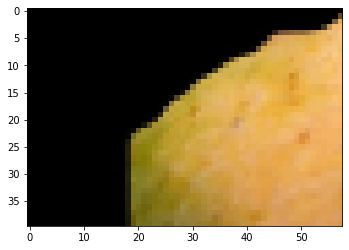

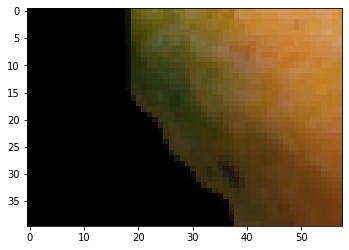

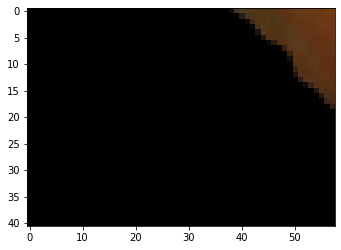

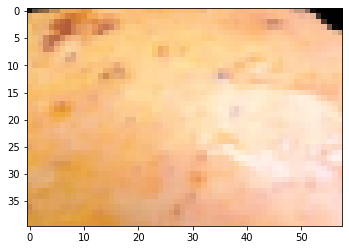

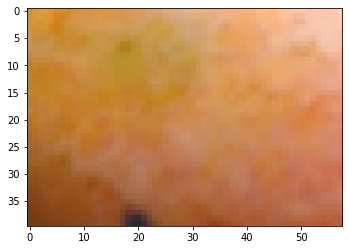

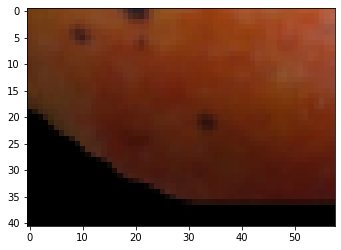

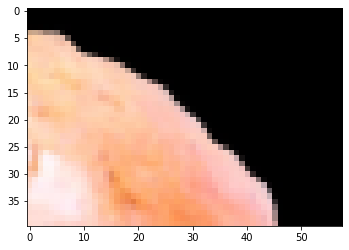

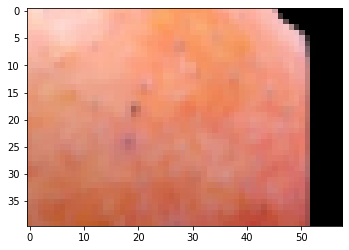

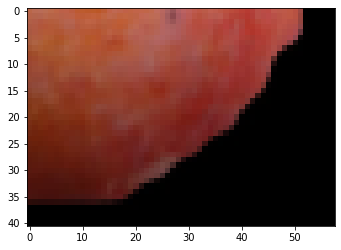

0.05359830706353648 0.031336479201001 0.04266385375374845


In [ ]:
crop_base=3
crop_img=[]
all_rgb=[]
r_all=0
g_all=0
b_all=0
for i in range(crop_base):
  for j in range(crop_base):
    crop_img.append(resized[int(resized.shape[0]*j/crop_base):int(resized.shape[0]*(1+j)/crop_base), int(resized.shape[1]*i/crop_base):int(resized.shape[1]*(1+i)/crop_base)])
    all_rgb.append(RGB_rates(crop_img[j+crop_base*i]))
    r_all+=RGB_rates(crop_img[j+crop_base*i])[0]
    g_all+=RGB_rates(crop_img[j+crop_base*i])[1]
    b_all+=RGB_rates(crop_img[j+crop_base*i])[2]
    show_img = cv2.cvtColor(crop_img[j+crop_base*i], cv2.COLOR_BGR2RGB)
    plt.imshow(show_img)
    plt.show()
r_average=r_all/crop_base**2
g_average=g_all/crop_base**2
b_average=b_all/crop_base**2
# print(all_rgb)
r_deviation=0
g_deviation=0
b_deviation=0
for i in all_rgb:
  r_deviation+=abs(r_average-i[0])
  g_deviation+=abs(g_average-i[1])
  b_deviation+=abs(b_average-i[2])
r_average_deviation=r_deviation/crop_base**2
g_average_deviation=g_deviation/crop_base**2
b_average_deviation=b_deviation/crop_base**2
print(r_average_deviation,g_average_deviation,b_average_deviation)

# Support Vector Machine

In [ ]:
X = [[0, 0], [1, 1]]
y=[0,1]

In [ ]:
import pandas
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

mango = pandas.read_csv("/content/drive/My Drive/data/mango_1.csv") 
X = mango[1:-1].values
Y = mango[-1].values
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)
X = StandardScaler().fit_transform(X)
X_train , X_test, y_train, y_test = train_test_split(X,Y)
clf = SVC(C=1.0, kernel='rbf').fit(X_train,y_train)

In [ ]:
from sklearn import svm
from sklearn import metrics

clf=svm.SVC()
clf.fit(X,y)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
print(metrics.accuracy_score([1,8],clf.predict([[1,1],[7,9]])))

0.5
